# End-To-End Handwriting Recognition

In [ ]:
import difflib
import importlib
import math
import random
import string

random.seed(123)
import cv2
import gluonnlp as nlp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mxnet as mx
import numpy as np
from skimage import transform as skimage_tf, exposure
from tqdm import tqdm


from ocr.utils.expand_bounding_box import expand_bounding_box
from ocr.utils.sclite_helper import ScliteHelper
from ocr.utils.word_to_line import sort_bbs_line_by_line, crop_line_images
from ocr.utils.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from ocr.utils.encoder_decoder import Denoiser, ALPHABET, encode_char, decode_char, EOS, BOS
from ocr.utils.beam_search import ctcBeamSearch


import ocr.utils.denoiser_utils
import ocr.utils.beam_search

importlib.reload(ocr.utils.denoiser_utils)
from ocr.utils.denoiser_utils import SequenceGenerator

importlib.reload(ocr.utils.beam_search)
from ocr.utils.beam_search import ctcBeamSearch


from ocr.paragraph_segmentation_dcnn import SegmentationNetwork, paragraph_segmentation_transform
from ocr.word_and_line_segmentation import SSD as WordSegmentationNet, predict_bounding_boxes
from ocr.handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform
from ocr.handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding



In [20]:
ctx = mx.cpu(0)# if mx.context.num_gpus() > 0 else mx.cpu()

## Dataset creation
Obtain the original forms from the IAM dataset and plot the results. Randomly select 4 images for analysis.

In [21]:
im11 = np.asarray(cv2.imread('test1.png', cv2.IMREAD_GRAYSCALE))
im12 = np.asarray(cv2.imread('test2.png', cv2.IMREAD_GRAYSCALE))
im13 = np.asarray(cv2.imread('test3.png', cv2.IMREAD_GRAYSCALE))
im14 = np.asarray(cv2.imread('test4.png', cv2.IMREAD_GRAYSCALE))
im15 = np.asarray(cv2.imread('test5.png', cv2.IMREAD_GRAYSCALE))

In [22]:
random.seed(1)


# In[5]:


figs_to_plot = 4
images = []
images.append(im11)
images.append(im13)
images.append(im12)
images.append(im14)

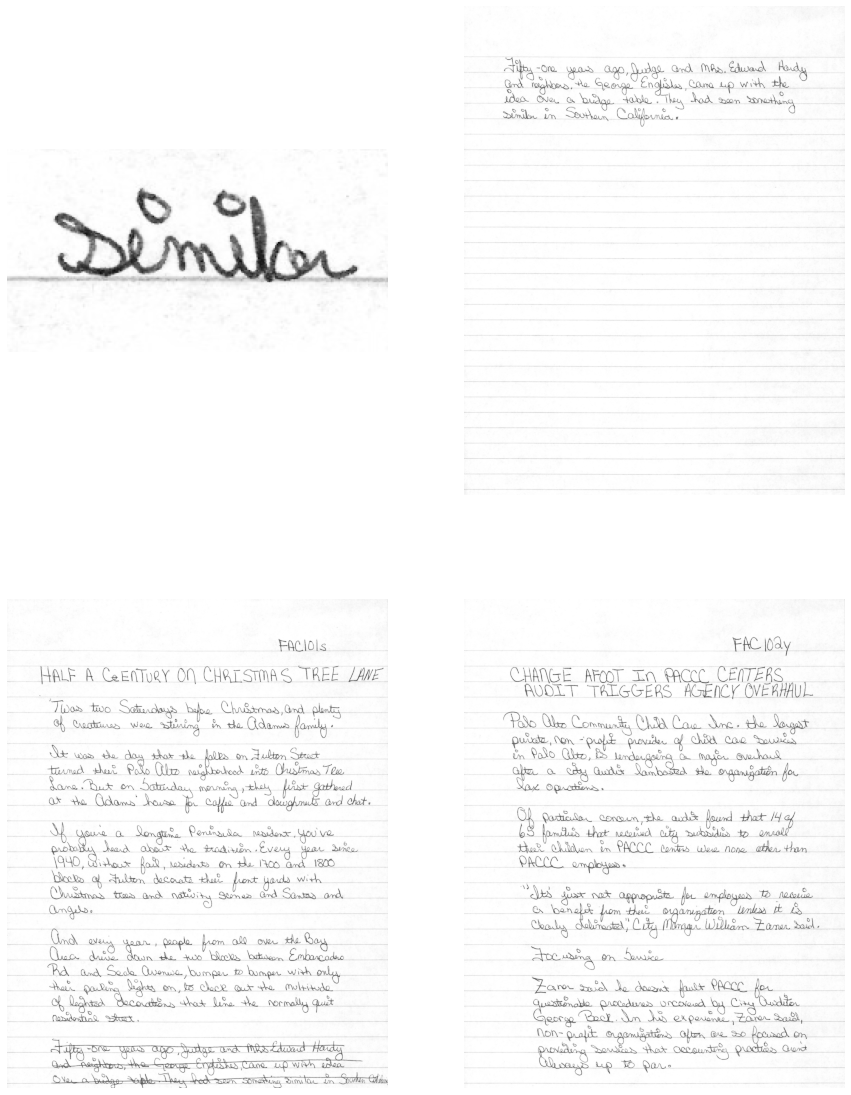

In [23]:
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 10 * len(images)/2))
for i, image in enumerate(images):
    y, x = int(i/2), int(i%2)
    axs[y, x].imshow(image, cmap='Greys_r')
    axs[y, x].axis('off')

### Paragraph segmentation

In [24]:
paragraph_segmentation_net = SegmentationNetwork(ctx=ctx)
paragraph_segmentation_net.cnn.load_parameters("models/paragraph_segmentation2.params", ctx=ctx)

In [25]:
paragraph_segmentation_net.hybridize()

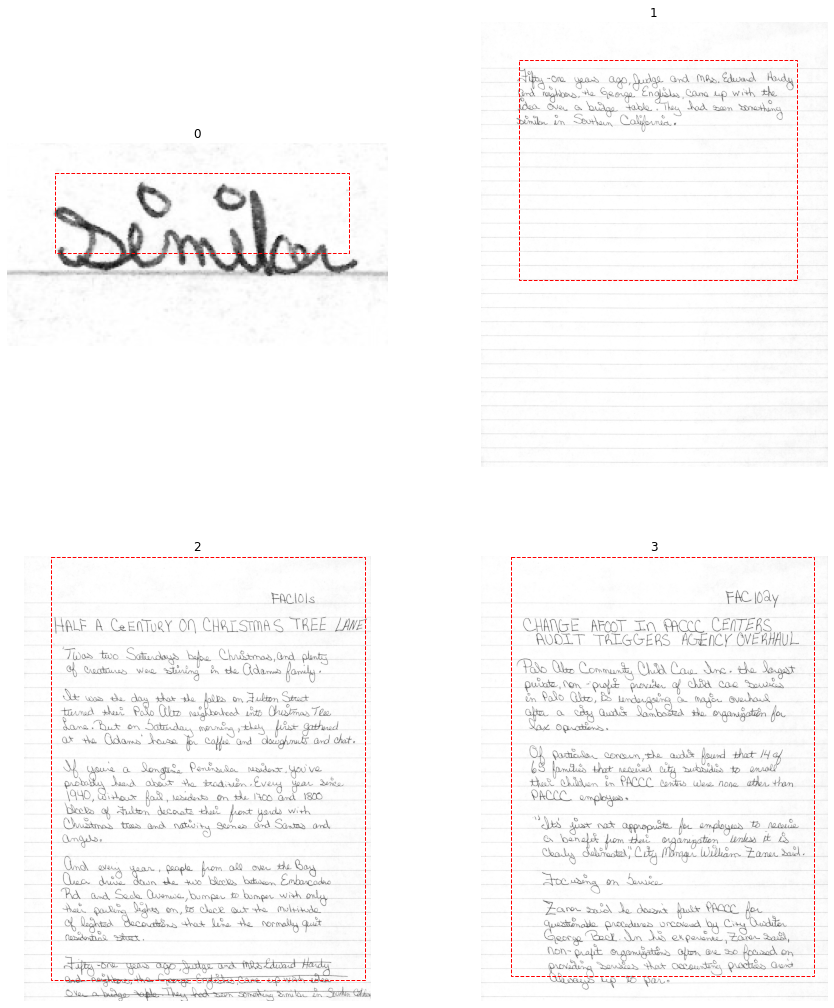

In [34]:
form_size = (1120, 800)

predicted_bbs = []

fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)
    resized_image = paragraph_segmentation_transform(image, form_size)
    
    bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
    bb_predicted = bb_predicted[0].asnumpy()
    bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.03,
                                           expand_bb_scale_y=0.7)
    predicted_bbs.append(bb_predicted)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    #axs[s_y, s_x].imshow(resized_image, cmap='Greys_r')
    axs[s_y, s_x].set_title("{}".format(i))

    (x, y, w, h) = bb_predicted
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[s_y, s_x].add_patch(rect)
    axs[s_y, s_x].axis('off')

## Image Processing

Crop the handwriting component out of the original IAM form.



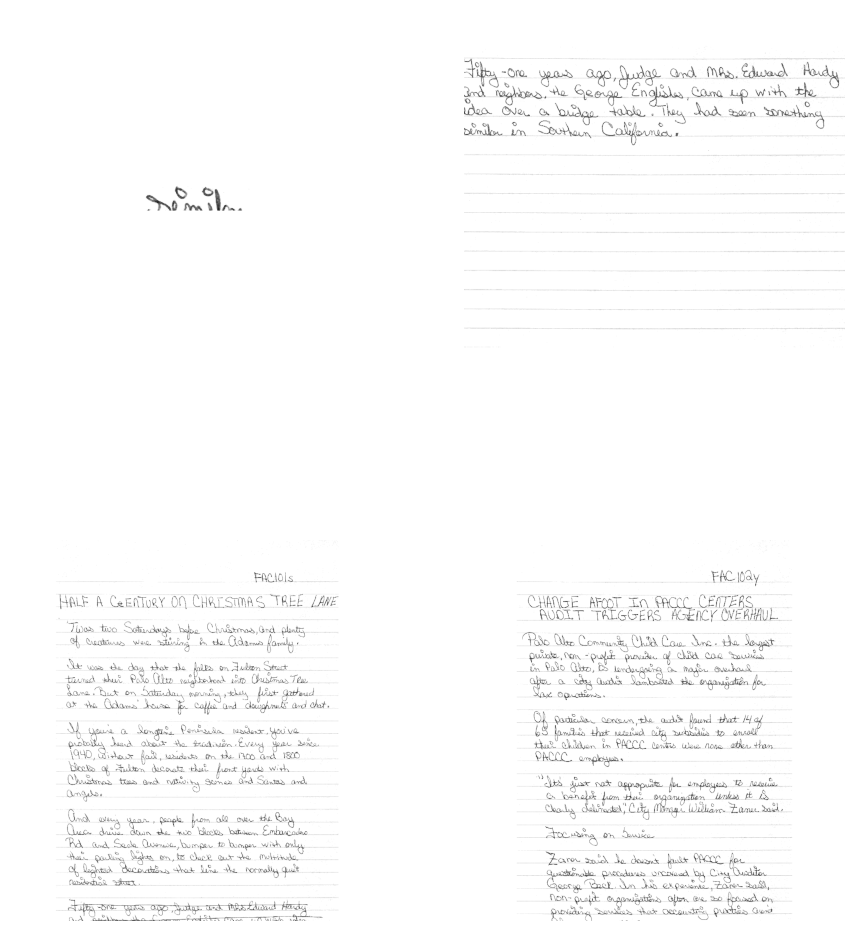

In [35]:
segmented_paragraph_size = (700, 700)
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))

paragraph_segmented_images = []

for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)

    bb = predicted_bbs[i]
    image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
    paragraph_segmented_images.append(image)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')

## word segmentation

In [36]:
word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("models/word_segmentation2.params")
word_segmentation_net.hybridize()

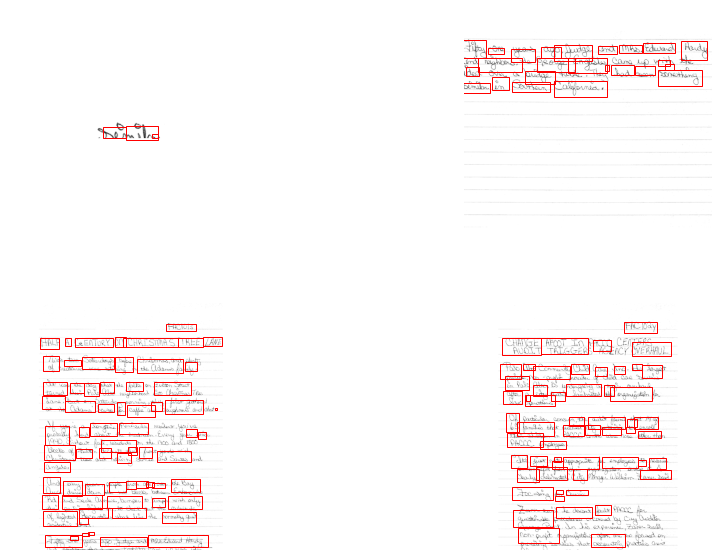

In [37]:
min_c = 0.1
overlap_thres = 0.1
topk = 600

fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 5 * int(len(paragraph_segmented_images)/2)))
predicted_words_bbs_array = []

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)

    predicted_bb = predict_bounding_boxes(
        word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)

    predicted_words_bbs_array.append(predicted_bb)
    
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    for j in range(predicted_bb.shape[0]):     
        (x, y, w, h) = predicted_bb[j]
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)
        axs[s_y, s_x].axis('off')

### Word to line image processing
Algorithm to sort then group all words within a line together.

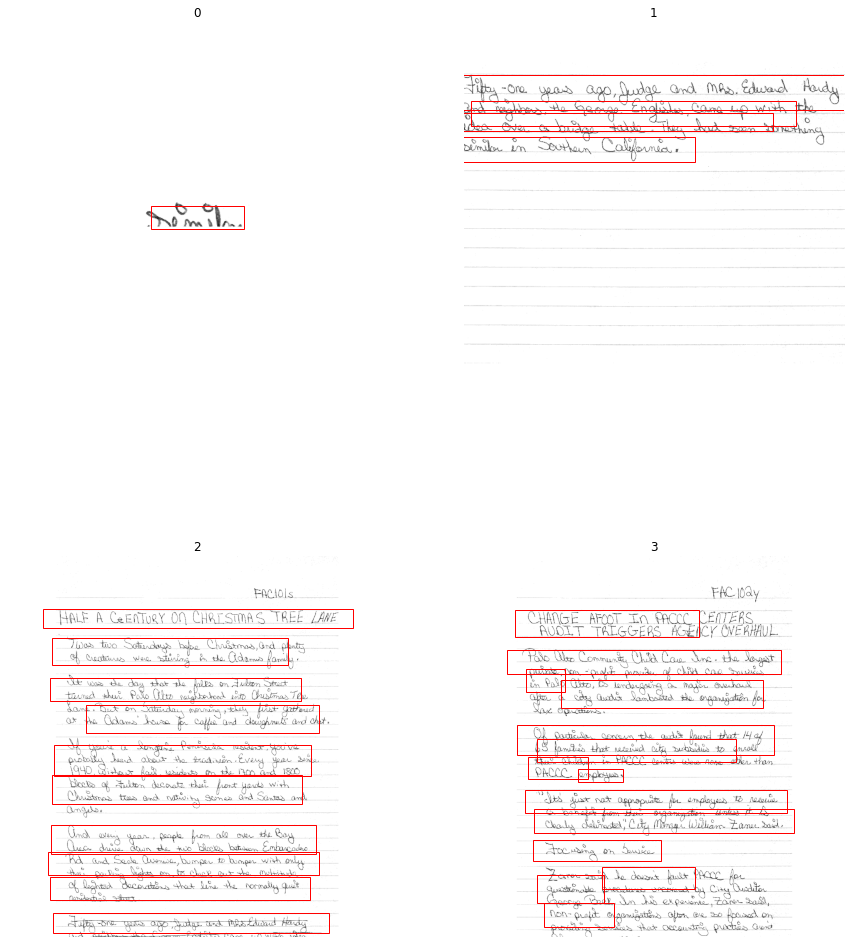

In [66]:
line_images_array = []
fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 9 * int(len(paragraph_segmented_images)/2)))

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')
    axs[s_y, s_x].set_title("{}".format(i))
    
    predicted_bbs = predicted_words_bbs_array[i]
    line_bbs = sort_bbs_line_by_line(predicted_bbs, y_overlap=0.8)
    line_images = crop_line_images(paragraph_segmented_image, line_bbs)
    line_images_array.append(line_images)
    
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)

## Handwriting recognition
Given each line of text, predict a string of the handwritten text. This network was trained with https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/language_model/handwriting_line_recognition.py

In [56]:
handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=512,
                                                             rnn_layers=2, ctx=ctx, max_seq_len=160)
handwriting_line_recognition_net.load_parameters("models/handwriting_line8.params", ctx=ctx)
handwriting_line_recognition_net.hybridize()

In [57]:
line_image_size = (60, 800)
character_probs = []
for line_images in line_images_array:
    form_character_prob = []
    for i, line_image in enumerate(line_images):
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        form_character_prob.append(line_character_prob)
    character_probs.append(form_character_prob)

### Character Probalities to Text

In [58]:
def get_arg_max(prob):
    '''
    The greedy algorithm convert the output of the handwriting recognition network
    into strings.
    '''
    arg_max = prob.topk(axis=2).asnumpy()
    return decoder_handwriting(arg_max)[0]

In [59]:
def get_beam_search(prob, width=5):
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, None, width)
    return possibilities[0]

## Denoising the text output

We use a seq2seq denoiser to translate noisy input to better output

In [60]:
FEATURE_LEN = 150
denoiser = Denoiser(alphabet_size=len(ALPHABET), max_src_length=FEATURE_LEN, max_tgt_length=FEATURE_LEN, num_heads=16, embed_size=256, num_layers=2)
denoiser.load_parameters('models/denoiser2.params', ctx=ctx)

In [61]:
denoiser.hybridize(static_alloc=True)

We use a language model in order to rank the propositions from the denoiser

In [45]:
ctx_nlp = mx.cpu(3)
language_model, vocab = nlp.model.big_rnn_lm_2048_512(dataset_name='gbw', pretrained=True, ctx=ctx_nlp)
moses_tokenizer = nlp.data.SacreMosesTokenizer()
moses_detokenizer = nlp.data.SacreMosesDetokenizer()

We use beam search to sample the output of the denoiser

In [46]:
beam_sampler = nlp.model.BeamSearchSampler(beam_size=20,
                                           decoder=denoiser.decode_logprob,
                                           eos_id=EOS,
                                           scorer=nlp.model.BeamSearchScorer(),
                                           max_length=150)

In [47]:
generator = SequenceGenerator(beam_sampler, language_model, vocab, ctx_nlp, moses_tokenizer, moses_detokenizer)

In [48]:
def get_denoised(prob, ctc_bs=False):
    if ctc_bs: # Using ctc beam search before denoising yields only limited improvements a is very slow
        text = get_beam_search(prob)
    else:
        text = get_arg_max(prob)
    src_seq, src_valid_length = encode_char(text)
    src_seq = mx.nd.array([src_seq], ctx=ctx)
    src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
    encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
    states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                      encoder_valid_length=src_valid_length)
    inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
    output = generator.generate_sequences(inputs, states, text)
    return output.strip()

In [49]:
sentence = "This sentnce has an eror"
src_seq, src_valid_length = encode_char(sentence)
src_seq = mx.nd.array([src_seq], ctx=ctx)
src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                  encoder_valid_length=src_valid_length)
inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
print(sentence)
print("Choice")
print(generator.generate_sequences(inputs, states, sentence))

This sentnce has an eror
Choice
T h i s   s e n t e n c e 


## Qualitative Result

[AM] Araoton
[D ] A t r a c
[AM] Fity-gre, years, ago. Bngag and Go Ednengl fody
[D ] F i f t y - f i v e ,   y e a r s ,   a g o .   B
[AM] Iod" heghnoors." Me Gecige," "iriglghs, Game up with;
[D ] g o o d   " h i g h   m o o r s . "   T h e   G e o r g
[AM] ERoa Evie" on Bistin Fania TThor" had sniom Ie
[D ] F r o m   E v i l   " o n   B i s t   i n   F a
[AM] Derilon in Saushain Callfomiai"
[D ] D e v i l   o n   i n   S u s t a
[AM] HHAF A CREITURS ON CHRTESINAS TREE RANE
[D ] H A V E   A   C R E I T U R S   O N   C H
[AM] "Ty clatiria TtiCTsiatiatrr. aiIEtiomogad
[D ] " T h y   C h r i s t i a n   T h i s   T r
[AM] Etressdi Fta tiatdiaatilai SiT"OTitihaie
[D ] E x t r a s s e d   i n t o   t h a t   d
[AM] si aldanio hiodial gin ongia ia" abilfiatidraso
[D ] h i s   g o l d e n   i n t o   t r a d i a l   g
[AM] Ruigtigingia Riiiagaiagnigilinara ieeaair
[D ] R i g h t i n g i n g   i n   R i s i a g a
[AM] "Sobnino FGriaTingiRiTEaRiOTERTBiasiaion
[D ] " S o b n i o u s   o f   C

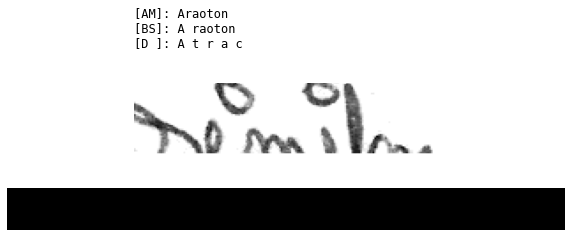

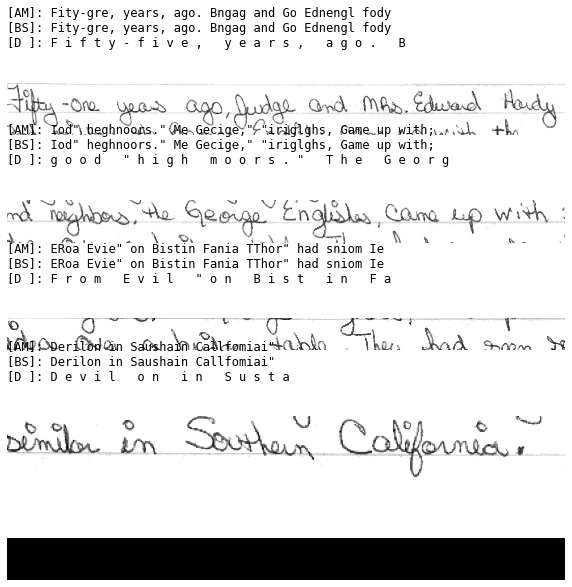

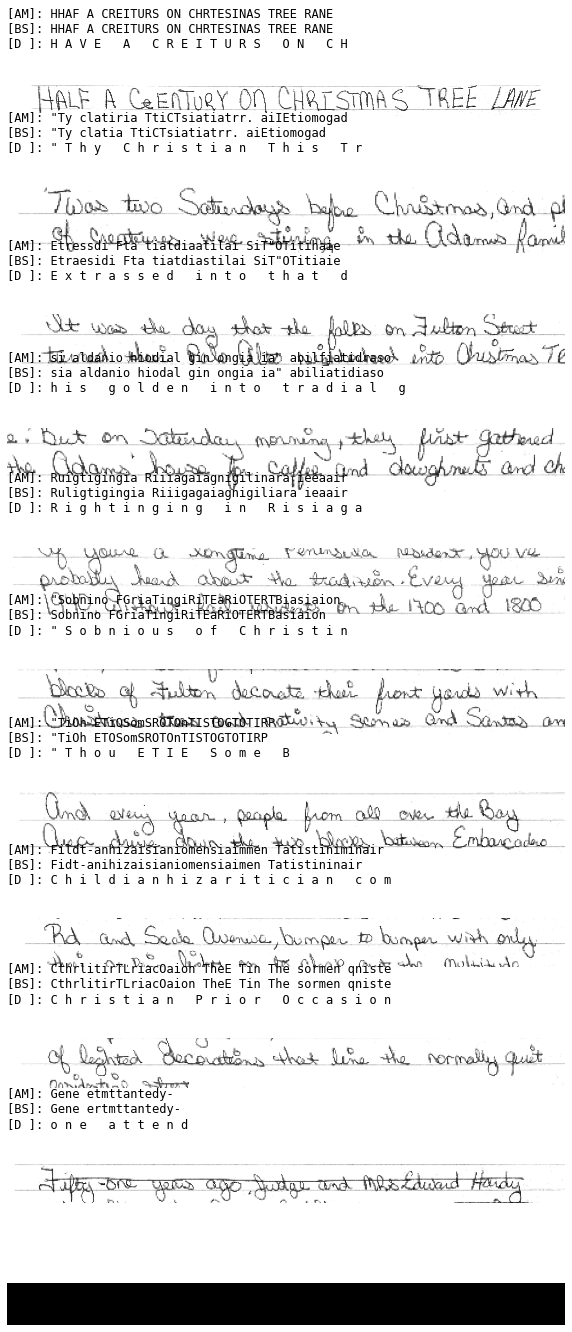

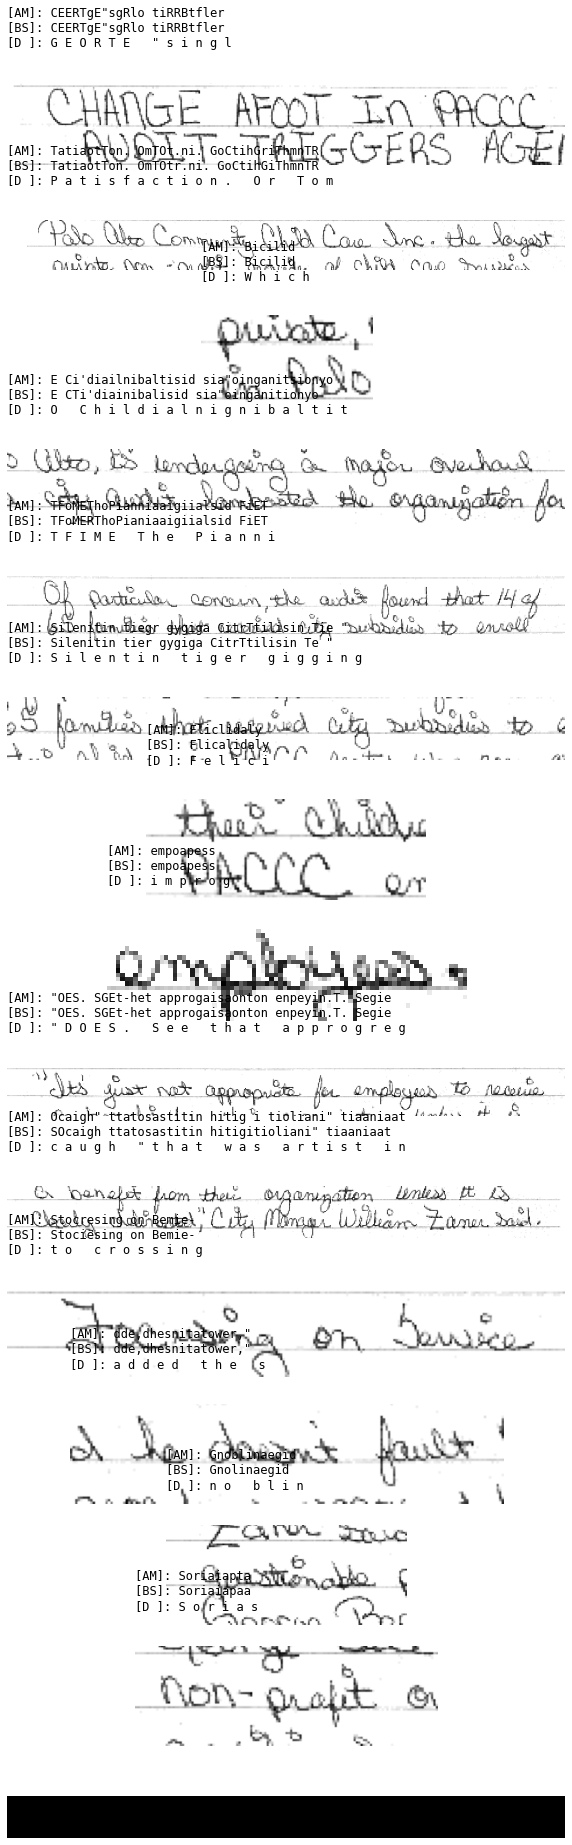

In [62]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(10, int(1 + 2.3 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line_am = get_arg_max(line_character_probs)
        
        print("[Before Denoising]",decoded_line_am)
        
        decoded_line_bs = get_beam_search(line_character_probs)
        decoded_line_denoiser = get_denoised(line_character_probs, ctc_bs=False)
        print("[After Denoising ]",decoded_line_denoiser)
        
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].set_title("[AM]: {}\n[BS]: {}\n[D ]: {}\n\n".format(decoded_line_am, decoded_line_bs, decoded_line_denoiser), fontdict={"horizontalalignment":"left", "family":"monospace"}, x=0)
        axs[j].axis('off')
        
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')